# Determining the age of customers

## Exploratory data analysis

In [1]:
import pandas as pd
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm_notebook as tqdm
from PIL import Image
import numpy as np

img_path = '/datasets/faces/final_files/'

In [2]:
labels = pd.read_csv('/datasets/faces/labels.csv')
train_datagen = ImageDataGenerator(rescale=1./255)
train_it = train_datagen.flow_from_dataframe(
      dataframe=labels,
      directory=img_path,
      x_col='file_name',
      y_col='real_age',
      target_size=(224, 224),
      batch_size=32,
      class_mode='raw',
      seed=12345) 

Found 7591 validated image filenames.


In [3]:
labels.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7591 entries, 0 to 7590
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   file_name  7591 non-null   object
 1   real_age   7591 non-null   int64 
dtypes: int64(1), object(1)
memory usage: 118.7+ KB


In [4]:
labels.head()

,file_name,real_age
0,000000.jpg,4
1,000001.jpg,18
2,000002.jpg,80
3,000003.jpg,50
4,000004.jpg,17


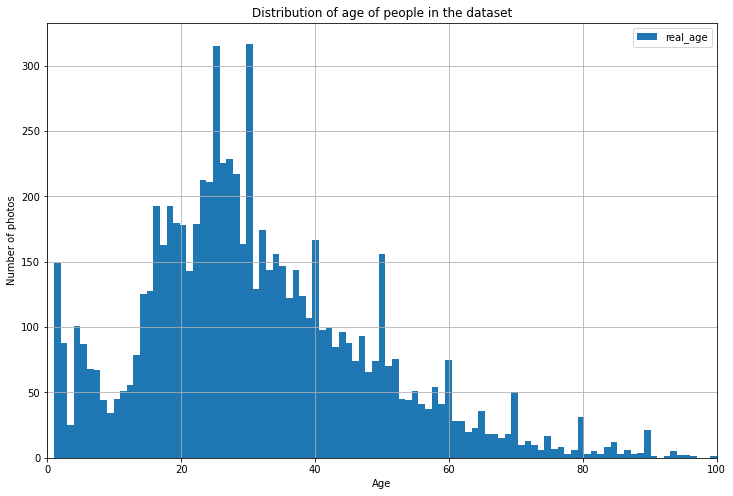

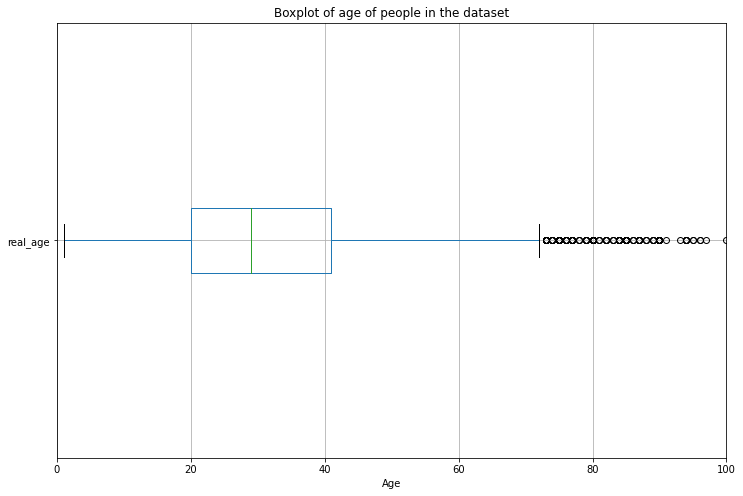

           count       mean       std  min   25%   50%   75%    max
real_age  7591.0  31.201159  17.14506  1.0  20.0  29.0  41.0  100.0


In [5]:
labels.plot(kind='hist', bins=100, figsize=(12, 8), grid=True, xlim=(0, 100))
plt.title('Distribution of age of people in the dataset')
plt.xlabel('Age')
plt.ylabel('Number of photos')
plt.show()

labels.plot(kind='box', figsize=(12, 8), grid=True, xlim=(0, 100), vert=False)
plt.title('Boxplot of age of people in the dataset')
plt.xlabel('Age')
plt.show()

print(labels.describe().T)


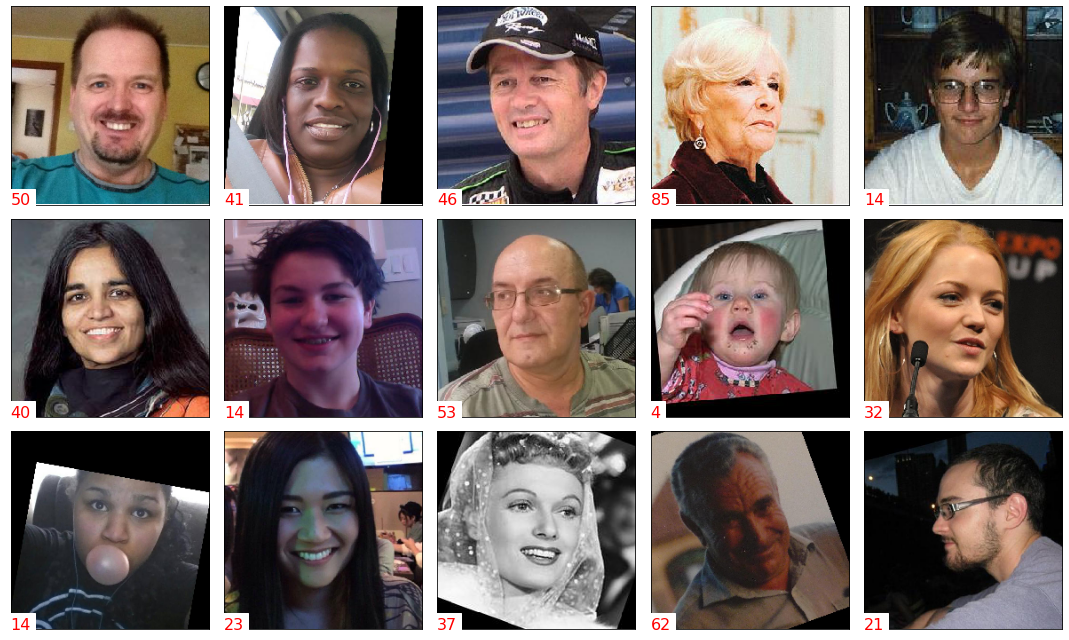

In [6]:
x, y = next(train_it)
fig = plt.figure(figsize=(15,9))
for i in range(15):
    ax = fig.add_subplot(3, 5, i+1)
    plt.imshow(x[i])
    plt.text(0, 0, y[i], fontsize = 16, transform=ax.transAxes,
             color='red', backgroundcolor='white')
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

<img src="https://emojigraph.org/media/apple/check-mark-button_2705.png" align=left width=33, heigth=33>
<div class="alert alert-success">
Молодец, что кроме изображений выводишь информацию о  возрасте </div>

In [7]:
img_sizes = labels.copy().set_index('file_name')
for file_name in tqdm(labels.file_name):
    img = Image.open(img_path+file_name)
    img_sizes.loc[file_name, ['h','w']] = img.size

img_sizes.sample(10)

  0%|          | 0/7591 [00:00<?, ?it/s]

,real_age,h,w
file_name,,,
006120.jpg,45,178.0,178.0
006650.jpg,30,119.0,120.0
001218.jpg,30,202.0,201.0
001913.jpg,24,689.0,689.0
005108.jpg,32,434.0,434.0
007386.jpg,50,111.0,111.0
005167.jpg,38,239.0,239.0
003586.jpg,70,379.0,379.0
005397.jpg,19,131.0,131.0


In [8]:
img_sizes['is_square'] = (img_sizes.h - img_sizes.w) <= 1
(~img_sizes.is_square).sum()

117

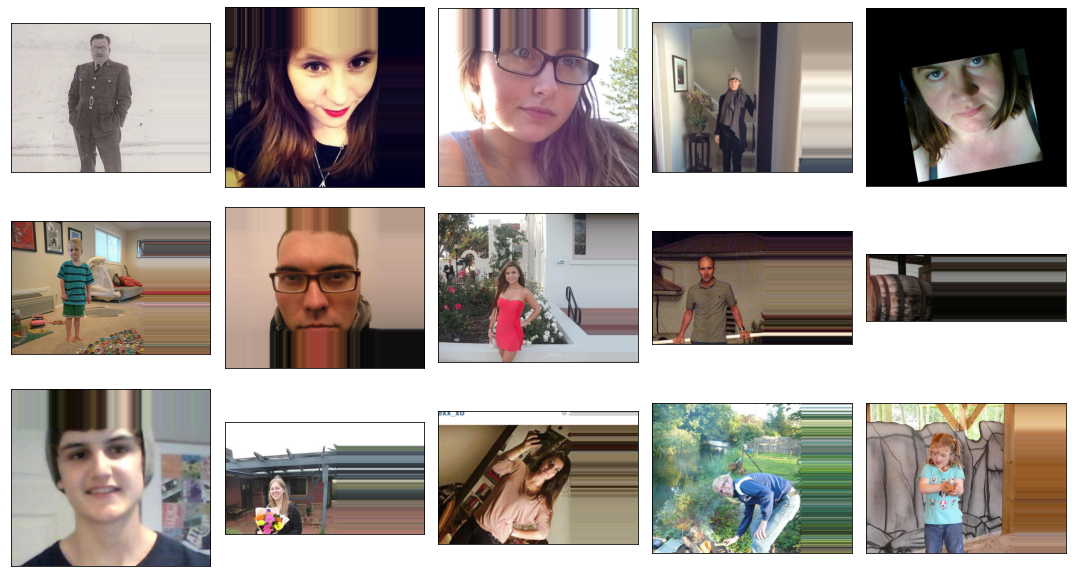

In [9]:
fig = plt.figure(figsize=(15,9))
i = 0
for file_name in img_sizes[~img_sizes.is_square].sample(15).index:
    i += 1
    fig.add_subplot(3, 5, i)
    plt.imshow(Image.open(img_path+file_name))
    plt.xticks([])
    plt.yticks([])
    plt.tight_layout()

We identified problems in the dataset. Namely, some photos:

- Not square: The presence of such photos may be due to errors in the process of saving images. When loading such images, the iterator method of the ImageDataGenerator class will convert them to square ones, thereby distorting them. However, the proportion of such images is small.

- Non-portrait photographs: Include full-length people, several people, etc., or do not contain faces or people at all. This is most likely due to errors in the detection algorithm.

The presence of such problematic images in the training set will cause the trained model to be prone to errors.

Dataset and its characteristics
- Dataset size: 7591 images.
- Data sufficiency assessment: For the ResNet50 model, which has a high capacity and requires a large amount of data for effective training, 7591 images may not be enough. Increasing the dataset size or using data augmentation techniques may be necessary to improve model performance.

## Model training

(The code in this section runs in a separate GPU simulator, so it is not formatted as a cell with code, but as code in a text cell)

```python

import numpy as np
import pandas as pd
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.layers import Conv2D, Flatten, AvgPool2D, Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.resnet import ResNet50


def load_train(path):
    labels = pd.read_csv(path+'labels.csv')
    train_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    train_datagen_flow = train_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='training',
        horizontal_flip=True,
        seed=42)
    return train_datagen_flow

def load_test(path):
    labels = pd.read_csv(path+'labels.csv')
    test_datagen = ImageDataGenerator(rescale= 1./255, validation_split=0.25)
    test_datagen_flow = test_datagen.flow_from_dataframe(
        dataframe = labels,
        directory = path + 'final_files/',
        x_col='file_name',
        y_col='real_age',
        target_size=(224, 224),
        batch_size=32,
        class_mode='raw',
        subset='validation',
        seed=42)

    return test_datagen_flow

def create_model(input_shape):

    backbone = ResNet50(input_shape= input_shape,
                    weights='imagenet',
                    include_top= False)

    model = Sequential()
    model.add(backbone)
    model.add(GlobalAveragePooling2D())
    model.add(Dense(1, activation='relu'))
    optimizer = Adam(lr=0.0005)
    model.compile(optimizer=optimizer, loss='mean_squared_error',metrics=['mae'])
    return model


def train_model(model, train_data, test_data, batch_size=None, epochs=10,
                steps_per_epoch=None, validation_steps=None):

    if steps_per_epoch is None:
        steps_per_epoch = len(train_data)
    if validation_steps is None:
        validation_steps = len(test_data)
    model.fit(train_data,
              validation_data= test_data,
              batch_size=batch_size, epochs=epochs,
              steps_per_epoch=steps_per_epoch,
              validation_steps=validation_steps,
              verbose=2)
    return model

```

```

Train for 178 steps, validate for 60 steps
Epoch 1/10
2024-07-07 22:14:17.460875: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcublas.so.10
2024-07-07 22:14:17.804604: I tensorflow/stream_executor/platform/default/dso_loader.cc:44] Successfully opened dynamic library libcudnn.so.7
178/178 - 54s - loss: 192.7433 - mae: 10.3793 - val_loss: 393.5318 - val_mae: 14.8068
Epoch 2/10
178/178 - 43s - loss: 97.2465 - mae: 7.4950 - val_loss: 360.3718 - val_mae: 14.0746
Epoch 3/10
178/178 - 44s - loss: 62.8094 - mae: 6.0719 - val_loss: 298.5473 - val_mae: 13.1008
Epoch 4/10
178/178 - 43s - loss: 42.5256 - mae: 4.9945 - val_loss: 159.8971 - val_mae: 9.5264
Epoch 5/10
178/178 - 43s - loss: 30.7741 - mae: 4.2733 - val_loss: 124.9490 - val_mae: 8.6167
Epoch 6/10
178/178 - 43s - loss: 24.1608 - mae: 3.7781 - val_loss: 82.2730 - val_mae: 6.9090
Epoch 7/10
178/178 - 44s - loss: 18.4981 - mae: 3.3033 - val_loss: 84.4197 - val_mae: 6.7738
Epoch 8/10
178/178 - 44s - loss: 14.9505 - mae: 2.9826 - val_loss: 73.1846 - val_mae: 6.4950
Epoch 9/10
178/178 - 44s - loss: 10.1414 - mae: 2.4378 - val_loss: 74.7914 - val_mae: 6.5780
Epoch 10/10
178/178 - 44s - loss: 8.3638 - mae: 2.1978 - val_loss: 74.9475 - val_mae: 6.4124
WARNING:tensorflow:sample_weight modes were coerced from
  ...
    to  
  ['...']
60/60 - 11s - loss: 74.9475 - mae: 6.4124
Test MAE: 6.4124

```

## Analysis of the trained model

The work used a ResNet neural network with a depth of 50 layers. The network was retrained on the used dataset. As a result of training the network for 10 epochs, the MAE for 25% of the data was 7.62, which is sufficient to complete the task and an overall good result. The model is clearly overfitted (MAE on the training set is 2.95), but the degree of overfitting is satisfactory.

It should be noted that, unfortunately, the simulator does not allow you to improve the result after achieving the required MAE value. If this were possible, it would be worth trying to use different augmentations, change the learning rate values, add regularization and change the number of epochs. Perhaps this would improve the result, and would certainly reduce the degree of overfitting.